# `BitVectorSet`: Sets as bit vectors

### Use

Efficient implementation of immutable sets of positive integers using bit vectors (we rely on the binary representation of positive integers, which is unbounded).

The `BitVectorSet` class follows the same specifications as `set` and `frozenset`.

In [10]:
from bitvectorset import BitVectorSet

A = BitVectorSet((0,2,4))
print("A =", A, len(A))
for i in A:
    print(i, "in", A)


B = BitVectorSet((0,1,2))
print("B =", B)

print("A & B = ", A & B, "=", A.intersection(B))
print("A | B = ", A | B, "=", A.union(B))
print("A - B = ", A - B, "=", A.difference(B))
print("A ^ B = ", A ^ B, "=", A.symmetric_difference(B))

A = {0, 2, 4} 3
0 in {0, 2, 4}
2 in {0, 2, 4}
4 in {0, 2, 4}
B = {0, 1, 2}
A & B =  {0, 2} = {0, 2}
A | B =  {0, 1, 2, 4} = {0, 1, 2, 4}
A - B =  {4} = {4}
A ^ B =  {1, 4} = {1, 4}


The package also provides an iterator over subsets.

In [11]:

from bitvectorset import iter_subsets

# Iterator over subsets of cardinality 2
print("Subsets of", A, "with size 2")
for C in iter_subsets(A, k=2):
    print(C, len(C))
    
# Iterator over all subsets
print("All subsets of", A)
for C in iter_subsets(A, k=None):
    print(C, len(C))

# By default, the class is `BitVectorSet`
# You can choose the appropriate class using the cls argument
print("Subsets of", A, "with size 2 as `set`")
for C in iter_subsets(A, k=2, cls=set):
    print(C, C.__class__.__name__)

Subsets of {0, 2, 4} with size 2
{0, 2} 2
{0, 4} 2
{2, 4} 2
All subsets of {0, 2, 4}
{} 0
{0} 1
{2} 1
{4} 1
{0, 2} 2
{0, 4} 2
{2, 4} 2
{0, 2, 4} 3
Subsets of {0, 2, 4} with size 2 as `set`
{0, 2} set
{0, 4} set
{2, 4} set


Using BitVectorSet, it might be more efficient to iterate over integers if you need all subsets of $\{0, \dots, n-1\}$ without taking into account the order of the elements obtained. 

In [12]:
n = 3
for i in range(1<<n):
    print(BitVectorSet.from_int(i))

{}
{0}
{1}
{0, 1}
{2}
{0, 2}
{1, 2}
{0, 1, 2}


Finally, the IndexedBitVectorSet class allows BitVectorSet to be used with any type of hashable element, by managing an index. However, this may be less efficient and more costly, depending on the operations requested.

In [13]:
from bitvectorset import IndexedBitVectorSet

C = IndexedBitVectorSet(("a", (1,2,3), 0))
D = IndexedBitVectorSet(("abc", 42, (1,2,3)))

print("C =", C)
print("D =", D)
print("C & D =", C & D)
print("C | D =", C | D)

C = {a, (1, 2, 3), 0}
D = {(1, 2, 3), abc, 42}
C & D = {(1, 2, 3)}
C | D = {a, (1, 2, 3), 0, abc, 42}


### A comparison of `BitVectorSet` and `frozenset`

In [14]:
from time import time

n = 20
print("Sets with n <", n, "   ==>   ", 2**n, "subsets")

# Instanciation time
t0 = time()
bvsets = list(iter_subsets(range(n)))
print("Creation of the", 2**n, "subsets using `BitVectorSets`:\t", time()-t0)

t0 = time()
frozensets = list(iter_subsets(range(n), cls=frozenset))
print("Creation of the", 2**n, "subsets using `frozenset`:\t", time()-t0)

t0 = time()
_ = [BitVectorSet.from_int(i) for i in range(1<<n)]
print("Creation of the", 2**n, "subsets using int-iteration:\t", time()-t0)

Sets with n < 20    ==>    1048576 subsets
Creation of the 1048576 subsets using `BitVectorSets`:	 1.1360955238342285
Creation of the 1048576 subsets using `frozenset`:	 1.226452350616455
Creation of the 1048576 subsets using int-iteration:	 0.40534090995788574


In [15]:
import pandas as pd
from random import sample

sizes = range(100, 1001, 100)
ops = {
    "Cardinality": lambda a, _: len(a),
    "Intersection": lambda a, b: a & b,
    "Union":  lambda a, b: a | b,
    "Difference": lambda a, b: a - b,
    "Symmetric diff": lambda a, b: a ^ b
}
n_sets = 100

df1 = pd.DataFrame(columns=ops.keys(), index=sizes)
df2 = pd.DataFrame(columns=ops.keys(), index=sizes)

for size in sizes:

    # Generation
    bvs, frs = [], []
    for _ in range(n_sets):
        items = sample(list(range(2*size)), size)
        bvs.append(BitVectorSet(items))
        frs.append(frozenset(items))

    ## bitvectorset 
    for k, op in ops.items():
        t0 = time()
        for A in bvs:
            for B in bvs:
                x = op(A, B)
        df1.loc[size, k] = time() - t0

    # frozenset
    for k, op in ops.items():
        t0 = time()
        for A in frs:
            for B in frs:
                x = op(A, B)
        df2.loc[size, k] = time() - t0

Except for the `len` operation, `BitVectorSet` is much more efficient than `frozenset`.

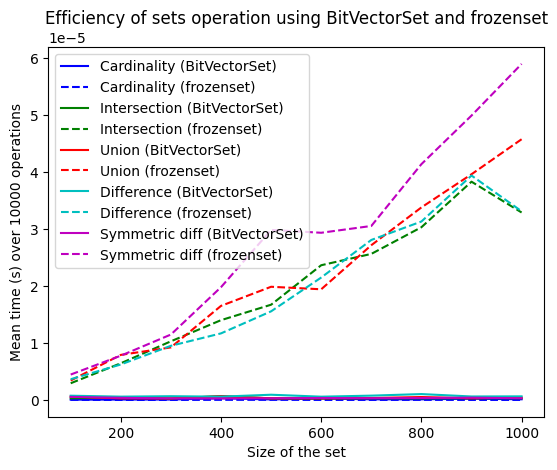

In [16]:
import matplotlib.pyplot as plt

colors = "bgrcm"
legend = []
for i, lbl in enumerate(ops.keys()):
    plt.plot(df1[lbl] / (n_sets**2), colors[i])
    plt.plot(df2[lbl] / (n_sets**2), colors[i]+'--')
    legend += [lbl+" (BitVectorSet)", lbl+" (frozenset)"]
plt.title("Efficiency of sets operation using BitVectorSet and frozenset")
plt.legend(legend)
plt.xlabel("Size of the set")
plt.ylabel(f"Mean time (s) over {n_sets**2} operations")
plt.show()

Operations on `BitVectorSet` appear to be constant time, but they actually depend on $n$. However, very large sets must be used for this effect to be noticeable.

In [17]:
sizes = range(10000, 100001, 10000)
df3 = pd.DataFrame(columns=ops.keys(), index=sizes)

for size in sizes:

    # Generation
    bvs = []
    for _ in range(n_sets):
        items = sample(list(range(2*size)), size)
        bvs.append(BitVectorSet(items))
        
    ## bitvectorset 
    for k, op in ops.items():
        t0 = time()
        for A in bvs:
            for B in bvs:
                x = op(A, B)
        df3.loc[size, k] = time() - t0

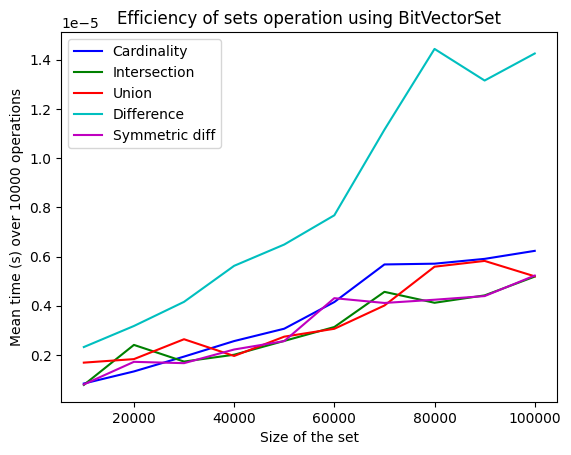

In [18]:
import matplotlib.pyplot as plt

colors = "bgrcm"
for i, lbl in enumerate(ops.keys()):
    plt.plot(df3[lbl] / (n_sets**2), colors[i])
plt.legend(ops.keys())
plt.title("Efficiency of sets operation using BitVectorSet")
plt.xlabel("Size of the set")
plt.ylabel(f"Mean time (s) over {n_sets**2} operations")
plt.show()